In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
# import pandas_profiling as pp

# models
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")
print("✔️ All Libraries imported")

✔️ All Libraries imported


In [3]:
df=pd.read_csv("used_cars preprocesssing(1).csv")

In [4]:
pd.set_option('display.max_rows', 10)

In [5]:
df.duplicated().sum()

0

In [6]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,condition
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6 Speed Automatic,Black,Black,1,Yes,"$10,300",NaN
1,Hyundai,Palisade SELl,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8 Speed Automatic,Moonlight Cloud,Gray,1,Yes,"$38,005",NaN
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598",NaN
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7 Speed Automatic,Black,Black,None reported,Yes,"$15,500",NaN
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8 Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999",NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4009 non-null   object 
 1   model         4009 non-null   object 
 2   model_year    4009 non-null   int64  
 3   milage        4009 non-null   object 
 4   fuel_type     3839 non-null   object 
 5   engine        4009 non-null   object 
 6   transmission  4009 non-null   object 
 7   ext_col       4009 non-null   object 
 8   int_col       4009 non-null   object 
 9   accident      3896 non-null   object 
 10  clean_title   3413 non-null   object 
 11  price         4009 non-null   object 
 12  condition     0 non-null      float64
dtypes: float64(1), int64(1), object(11)
memory usage: 407.3+ KB


In [7]:
j=df[df['engine']==' '].index

In [8]:
df.drop(j,inplace=True)

In [9]:
df.drop(columns=df.columns[12],inplace=True )

In [10]:
df.isnull().sum()

brand            0
model            0
model_year       0
milage           0
fuel_type      170
              ... 
ext_col          0
int_col          0
accident       112
clean_title    595
price            0
Length: 12, dtype: int64

In [11]:
# here we can see that we have to derive information from each columns:
# 1.milage = d_in_km
# 2.engine = hp
#          = litre
#          = v
#          = no_of_cylinders
# 3.Transmission = atomatic/mannual/dual
#                = gear


In [12]:
df['horsepower'] = df['engine'].str.extract(r'(\d+\.\d+)HP', expand=False).astype(float)
df['horsepower']

0       300.0
1         NaN
2         NaN
3       354.0
4         NaN
        ...  
4004      NaN
4005    349.0
4006      NaN
4007    450.0
4008    248.0
Name: horsepower, Length: 3964, dtype: float64

In [13]:
df['Displacement'] = df['engine'].str.extract(r'(\d+\.\d+)L', expand=False).astype(float).fillna(df['engine'].str.extract(r'(\d+(\.\d+)?)\s*Liter', expand=False)[0].astype(float))
df['Displacement']

0       3.7
1       3.8
2       3.5
3       3.5
4       2.0
       ... 
4004    6.0
4005    3.0
4006    NaN
4007    3.5
4008    2.0
Name: Displacement, Length: 3964, dtype: float64

In [14]:
df['engine'].str.extract(r'(\d+\.\d+)', expand=False).astype(float)

0       300.0
1         3.8
2         3.5
3       354.0
4         2.0
        ...  
4004      6.0
4005    349.0
4006      NaN
4007    450.0
4008    248.0
Name: engine, Length: 3964, dtype: float64

In [15]:
df['Cylinders']= (df['engine'].str.extract(r'(\d+)\s*Cylinder', expand=False) )
df['Cylinders'].value_counts(dropna=False)


Cylinders
6      1225
8      1007
NaN     900
4       739
12       37
10       23
5        20
3        13
Name: count, dtype: int64

In [16]:
df['transmission'].str.contains(r'Dual', case=False).astype(str)

0       False
1       False
2       False
3       False
4       False
        ...  
4004    False
4005     True
4006    False
4007    False
4008    False
Name: transmission, Length: 3964, dtype: object

In [17]:
df['transmission'].str.extract(r'(\d+)Speed', expand=False).astype(float).value_counts(dropna=False)

transmission
NaN    3964
Name: count, dtype: int64

In [18]:
df['Gear']=df['transmission'].str.extract(r'(\d+) Speed', expand=False).astype(float).fillna(df['transmission'].str.contains(r'Dual', case=False))
df['Gear'].value_counts(dropna=False)

Gear
False    1428
6.0       695
8.0       591
True      477
7.0       254
10.0      176
5.0       147
9.0       120
4.0        72
2.0         4
Name: count, dtype: int64

In [19]:
df['Transmission']=df['transmission'].str.lower().str.extract(r'(\bautomatic\b|\bmanual\b|\bdual\b)')

In [20]:
df['Transmission'].value_counts()

Transmission
automatic    3118
dual          396
manual         15
Name: count, dtype: int64

In [21]:
df['Gear'].replace({
     True:1,
     False:np.nan
},inplace=True)

In [22]:
df.isnull().sum()

brand              0
model              0
model_year         0
milage             0
fuel_type        170
                ... 
horsepower       765
Displacement     193
Cylinders        900
Gear            1428
Transmission     435
Length: 17, dtype: int64

In [23]:
y=['accident','clean_title','horsepower','Displacement','Cylinders','Gear','Transmission']

for x in y:
  print(df[x].value_counts(dropna=False))
  print('----------------------------------')

accident
None reported    2877
1                 975
NaN               112
Name: count, dtype: int64
----------------------------------
clean_title
Yes    3369
NaN     595
Name: count, dtype: int64
----------------------------------
horsepower
NaN      765
300.0    107
400.0     71
420.0     71
355.0     70
        ... 
258.0      1
78.0       1
133.0      1
121.0      1
176.0      1
Name: count, Length: 349, dtype: int64
----------------------------------
Displacement
2.0    524
3.0    469
3.5    353
3.6    241
NaN    193
      ... 
8.4      1
7.4      1
1.7      1
8.0      1
1.0      1
Name: count, Length: 62, dtype: int64
----------------------------------
Cylinders
6      1225
8      1007
NaN     900
4       739
12       37
10       23
5        20
3        13
Name: count, dtype: int64
----------------------------------
Gear
NaN     1428
6.0      695
8.0      591
1.0      477
7.0      254
10.0     176
5.0      147
9.0      120
4.0       72
2.0        4
Name: count, dtype: int64
----

In [24]:
df['accident'].replace({
    'None reported': 0
},inplace=True)

In [25]:
df['accident'].fillna(0,inplace=True)

In [26]:
df['clean_title'].fillna('No',inplace=True)

In [27]:
df[df['Gear']==1]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,Displacement,Cylinders,Gear,Transmission
13,Lincoln,Aviator Reserve AWD,2022,"18,196 mi.",Gasoline,400.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission With Dual Shift Mode,Black,Brown,0,Yes,"$62,000",400.0,3.0,6,1.0,dual
25,Hyundai,Elantra N Base,2022,"11,650 mi.",Gasoline,276.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Transmission With Dual Shift Mode,Black,Black,0,Yes,"$32,300",276.0,2.0,4,1.0,dual
44,Lucid,Air Grand Touring,2022,"3,552 mi.",NaN,536.0HP Electric Motor Electric Fuel System,1 Speed Automatic,Red,Beige,0,Yes,"$119,999",536.0,NaN,NaN,1.0,automatic
50,Mercedes Benz,AMG C 63 S,2017,"60,000 mi.",Gasoline,503.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,Transmission With Dual Shift Mode,Gray,Black,1,Yes,"$52,500",503.0,4.0,8,1.0,dual
54,Mercedes Benz,CLA Class CLA 250,2016,"120,000 mi.",Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Transmission With Dual Shift Mode,Black,Black,0,Yes,"$19,800",208.0,2.0,4,1.0,dual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,Tesla,Model 3 Long Range,2021,"23,749 mi.",NaN,Electric,1 Speed Automatic,White,Black,0,No,"$35,999",NaN,NaN,NaN,1.0,automatic
3987,BMW,X3 xDrive28i,2015,"92,984 mi.",Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Transmission With Dual Shift Mode,White,Beige,1,Yes,"$17,000",240.0,2.0,4,1.0,dual
3994,BMW,M8 Gran Coupe Competition,2022,"21,057 mi.",Gasoline,617.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,Transmission With Dual Shift Mode,Gray,Black,0,Yes,"$99,800",617.0,4.4,8,1.0,dual
4001,Volkswagen,Routan SE,2011,"194,000 mi.",Gasoline,283.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,Transmission With Dual Shift Mode,Black,Gray,1,Yes,"$3,500",283.0,3.6,6,1.0,dual


In [28]:
# df['fuel_type'].fillna('Electric',inplace=True)

In [29]:

condition=(df['fuel_type']=='Electric') & (df['horsepower'].isnull())
df.loc[condition, 'horsepower'] = 'Electric'


In [30]:
df['horsepower'].value_counts(dropna=False)

horsepower
NaN      765
300.0    107
400.0     71
420.0     71
355.0     70
        ... 
258.0      1
78.0       1
133.0      1
121.0      1
176.0      1
Name: count, Length: 349, dtype: int64

In [31]:
df_temp=df.copy()

In [32]:
df_temp.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,Displacement,Cylinders,Gear,Transmission
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6 Speed Automatic,Black,Black,1,Yes,"$10,300",300.0,3.7,6,6.0,automatic
1,Hyundai,Palisade SELl,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8 Speed Automatic,Moonlight Cloud,Gray,1,Yes,"$38,005",NaN,3.8,NaN,8.0,automatic
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,0,No,"$54,598",NaN,3.5,NaN,NaN,automatic
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7 Speed Automatic,Black,Black,0,Yes,"$15,500",354.0,3.5,6,7.0,automatic
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8 Speed Automatic,Glacier White Metallic,Black,0,No,"$34,999",NaN,2.0,NaN,8.0,automatic


In [33]:
df_temp['horsepower'].fillna(df['engine'],inplace=True)

In [34]:
df_temp['horsepower'].value_counts(dropna=False)

horsepower
300.0                          107
400.0                           71
420.0                           71
355.0                           70
240.0                           61
                              ... 
294.0                            1
2.0L I4 16V GDI DOHC Hybrid      1
3.8L H6 24V MPFI DOHC            1
Dual AC Electric Motors          1
176.0                            1
Name: count, Length: 563, dtype: int64

In [35]:
# After drived the information from google about the horsepower:
df_temp['horsepower'].replace({

            '3.8L V6 24V GDI DOHC':333.0,
            '2.0L I4 16V GDI DOHC Turbo':416.0,
            '3.5L V6 24V PDI DOHC Twin Turbo':450.0,
            '2.0L I4 16V GDI DOHC Turbo Flexible Fuel':270.0,
            '3.0L V6 Cylinder Engine Diesel Fuel':277.0,
            '4.4 Liter DOHC Twin Turbo':617.0,
            '5.3L V8 16V GDI OHV':355.0,
            '2.4L I4 16V GDI DOHC':200.0,
            '1.5L I3 12V GDI DOHC Turbo':181.0,
            '5.2L V10 40V PDI DOHC':562.0,
            '5.2L V 10 gasoline direct injection, DOHC, variable valve contro':800.0,
            '1.6L I4 16V GDI DOHC Hybrid':138.0,
            '5.2L V12 48V GDI DOHC Twin Turbo':690.0,
            '5.7L V8 16V MPFI OHV':395.0,
            '6.2L V8 16V GDI OHV Supercharged':650.0,
            '5.0L V8 32V PDI DOHC':360.0,
            '3.0L V6 24V GDI DOHC Twin Turbo':500.0,
            '3.6L V6 24V MPFI DOHC': 350.0,
            '5.3L V8 16V MPFI OHV Flexible Fuel':400.0,
            '2.5L H4 16V GDI DOHC':300.0,
            '2.0L I4 16V GDI SOHC Turbo':300.0,
            '4.0L V6 24V MPFI DOHC':300.0,
            '1.5L I4 16V GDI DOHC Turbo':200.0,
            '4.0L V8 32V GDI DOHC Twin Turbo':600.0,
            '1.3L I3 12V GDI DOHC Turbo': 200.0,
            '3.8L H6 24V GDI DOHC Twin Turbo':450.0,
            '2.3L I4 16V GDI DOHC Turbo':350.0,
            '3.6L V6 24V GDI DOHC':350.0,
            '2.5L I4 16V GDI DOHC Turbo':300.0,
            '5.6L V8 32V GDI DOHC':350.0,
            '5.8L V8 32V MPFI DOHC Supercharged':700.0,
            '6.4L V8 16V MPFI OHV':500.0,
            '8.0L W16 64V GDI DOHC Twin Turbo':1400.0,
            '3.5L V6 24V PDI DOHC':350.0,
            '2.0L I4 16V MPFI DOHC':300.0,
            '2.9L V6 24V GDI DOHC Twin Turbo':500.0,
            '1.2L I3 12V GDI DOHC Turbo':150.0,
            '2.0 Liter DOHC Turbo':300.0,
            '2.5L I4 16V PDI DOHC Hybrid':250.0,
            '3.0L H6 24V GDI DOHC Twin Turbo':500.0,
            '6.8L V12 48V GDI DOHC':700.0,
            '2.5L I4 16V PDI DOHC':300.0,
            'AMG 3L I 6 gasoline direct injection, DOHC, variable valve contr':450.0,
            '1.6L I 4 gasoline direct injection, DOHC, variable valve control':200.0,
            '3.0L V6 24V GDI DOHC Turbo':400.0,
            '5.2L V10 40V GDI DOHC':600.0,
            '3.0L I6 24V DDI DOHC Turbo Diesel':300.0,
            '2.5L I4 16V GDI DOHC':300.0,
            '3.0L V6 24V GDI DOHC Supercharged':500.0,
            '6.2L V8 16V MPFI SOHC Flexible Fuel':500.0,
            'HEMI 5.7L V 8 variable valve control, regular unleaded, engine w':400.0,
            '3.6 Liter SIDI DOHC':350.0,
            '3.0 Liter DOHC Twin Turbo':500.0,
            '4.4L V8 32V GDI DOHC Twin Turbo':400.0,
            '1.5L I3 12V PDI DOHC Turbo':200.0,
            '6.6L V 12 gasoline direct injection, DOHC, variable valve contro':700.0,
            '6.7L V12 48V GDI DOHC Twin Turbo':800.0,
            '2.0L I4 16V GDI DOHC Turbo Hybrid':300.0,
            '3.0L I6 24V GDI DOHC Turbo':400.0,
            '5.7L V8 32V MPFI DOHC':350.0,
            '3.5L 24V SOHC I VTEC V6':350.0,
            '5L V 8 gasoline direct injection, DOHC, variable valve control,':500.0,
            '3.2L H6 24V MPFI DOHC': 300.0,
            '6.7L I6 24V DDI OHV Turbo Diesel':500.0,
            'HEMI 6.2L V 8 intercooled supercharger, premium unleaded, engine':800.0,
            '2.4L I4 16V MPFI SOHC':250.0,
            '3.5L V6 24V GDI SOHC':350.0,
            '6.0L W12 48V PDI DOHC Twin Turbo':650.0,
            '2L I 4 DOHC, D CVVT variable valve control, engine with 147HP':147.0,
            '3.4L V6 24V PDI DOHC Twin Turbo':500.0,
            '3.5L V6 24V PDI DOHC Hybrid':400.0,
            '4.4 Liter GDI DOHC Twin Turbo':600.0,
            '3.3L V6 24V GDI DOHC':350.0,
            '2.9L V 6 gasoline direct injection, DOHC, variable valve control':400.0,
            '3L I 6 gasoline direct injection, DOHC, Double VANOS variable va':400.0,
            '2.0L I4 16V GDI DOHC':300.0,
            '3.5L V6 24V GDI DOHC Twin Turbo':500.0,
            '2.5L I4 16V PDI DOHC Turbo':250.0,
            '3.6L V6 24V MPFI DOHC Hybrid':400.0,
            '2.4L I4 16V MPFI DOHC':250.0,
            '1.6L I4 16V GDI DOHC Turbo':200.0,
            '3.0L I6 24V GDI DOHC Twin Turbo':450.0,
            '6.7L V8 32V DDI OHV Turbo Diesel':500.0,
            '3.6L V6 24V MPFI DOHC Flexible Fuel':350.0,
            '3.4L V6 24V PDI DOHC Twin Turbo Hybrid':500.0,
            '2.5L I 4 DOHC, variable valve control, regular unleaded, engine':250.0,
            '6.0L 8 Cylinder Engine Gasoline Fuel':500.0,
            '6.0L V8 16V MPFI OHV':500.0,
            '2L I 4 gasoline direct injection, DOHC, variable valve control,':250.0,
            '2.0L I4 16V MPFI DOHC Hybrid':300.0,
            '2.4L I4 16V PDI DOHC Turbo':300.0,
            '6.2L V8 16V GDI OHV':700.0,
            '6.4L V8 32V DDI OHV Twin Turbo Diesel':600.0,
            '4.0L H6 24V GDI DOHC':500.0,
            '3.4L H6 24V MPFI DOHC':400.0,
            '6.6L V8 16V GDI OHV':600.0,
            '2.0L I4 16V GDI DOHC Hybrid':300.0,
            '3.8L H6 24V MPFI DOHC':500.0,
            '5.0L V8 32V GDI DOHC Supercharged':700.0,
            '3.5L V 6 port/direct injection, DOHC, VVT iE/VVT i variable valv':300.0,
            'Intercooled Turbo Premium Unleaded I 4 2.0 L/122':250.0,
            '6.5L V12 48V MPFI DOHC':800.0,
            '3.9L V8 32V GDI DOHC Twin Turbo':750.0,
            '3.0L V6 24V PDI DOHC Twin Turbo':500.0,
            '2.7L V6 24V GDI DOHC Twin Turbo': 500.0,
            '3.2L V6 18V MPFI SOHC':300.0,
            '2.5L I4 16V MPFI DOHC':250.0,
            '2.7L V6 24V PDI DOHC Twin Turbo':500.0,
            '6.8L V12 48V GDI DOHC Twin Turbo':800.0,
            '2L I 4 gasoline direct injection, MultiAir2 variable valve contr':300.0,
            '6.3L V12 48V GDI DOHC': 800.0,
            '6.6L V8 32V DDI OHV Turbo Diesel':500.0,
            '4.6L V8 32V MPFI DOHC':400.0,
            '4.2L V8 32V GDI DOHC':500.0,
            '4.2L V8 32V GDI DOHC Twin Turbo':700.0,
            '4.7L 8 Cylinder Engine Gasoline Fuel':400.0,
            '3.5L V 6 port/direct injection, DOHC, VVT iE variable valve cont':400.0,
            '6.5L V 12 DOHC, variable valve control, premium unleaded, engine':800.0,
            '2L H 4 gasoline direct injection, DOHC, variable valve control,':300.0,
            '4L V 8 gasoline direct injection, DOHC, variable valve control,':500.0,
            '2.0 Liter DOHC T/C':250.0,
            '3.5L V6 24V MPFI DOHC':400.0,
            'LAMBDA II 3.8L V 6 gasoline direct injection, DOHC, D CVVT varia':350.0,
            '2.0L I4 16V GDI DOHC Flexible Fuel':250.0,
            '2L H 4 DOHC, variable valve control, regular unleaded, engine wi':250.0,
            'Electric': '-',
            '1.6L I4 16V GDI DOHC Turbo Hybrid':250.0,
            '2.7L I4 16V GDI DOHC Turbo':350.0,
            '3.5L V6 24V PDI DOHC Twin Turbo Hybrid':500.0,
            '2.5L I4 16V MPFI DOHC Hybrid':250.0,
            '3.8L V8 32V GDI DOHC Twin Turbo':600.0,
            '2L I 4 gasoline direct injection, DOHC, intercooled turbo, engin':350.0,
            '6.0L V8 16V MPFI OHV Flexible Fuel':450.0,
            '3.8L V8 32V MPFI DOHC Twin Turbo':600.0,
            '3.6L V6 GDI DOHC': 350.0,
            '3.8L V6 24V MPFI DOHC Twin Turbo':500.0,
            '4L V 6 DOHC, VVT i variable valve control, engine with 270HP':270.0,
            '6L W 12 port/direct injection, DOHC, variable valve control, twi':800.0,
            '3.5L V6 24V GDI DOHC':400.0,
            '2.0L I4 16V PDI DOHC Turbo':350.0,
            '4L V 6 DOHC, VVT i variable valve control, regular unleaded, eng':400.0,
            '2.5L 4 Cylinder Engine Gasoline Fuel':250.0,
            '1.3L I3 12V MPFI DOHC Turbo':200.0,
            '6.2L V8 32V MPFI DOHC':700.0,
            '3.8L V6 12V MPFI OHV':300.0,
            '4L H 6 gasoline direct injection, DOHC, VarioCam Plus variable v':450.0,
            '3.2L V6 24V MPFI DOHC':300.0,
            '2.5L H4 16V MPFI DOHC':250.0,
            '2.4L H4 16V GDI DOHC Turbo':350.0,
            'Intercooled Turbo Diesel V 8 6.7 L/406':600.0,
            '1.6L I4 16V GDI DOHC':200.0,
            '2.7 Liter DOHC Turbo':350.0,
            '3.3L V 6 gasoline direct injection, DOHC, D CVVT variable valve':400.0,
            '1.6L I4 16V MPFI DOHC':200.0,
            '1.4L I4 16V GDI DOHC Turbo':200.0,
            '4.0L V8 32V MPFI DOHC Twin Turbo':600.0




},inplace=True)

In [36]:
df_temp['horsepower'].value_counts(dropna=False)

horsepower
300.0                   179
350.0                   142
400.0                   108
355.0                    89
500.0                    75
                       ... 
294.0                     1
6.6 Liter Twin Turbo      1
620.0                     1
691.0                     1
176.0                     1
Name: count, Length: 413, dtype: int64

In [37]:
# df_temp['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

In [38]:
df_temp['horsepower']

0                300.0
1                333.0
2       3.5 Liter DOHC
3                354.0
4                416.0
             ...      
4004             650.0
4005             349.0
4006                 -
4007             450.0
4008             248.0
Name: horsepower, Length: 3964, dtype: object

In [39]:
df=df_temp

In [40]:
df['horsepower'].value_counts(dropna=False)

horsepower
300.0                   179
350.0                   142
400.0                   108
355.0                    89
500.0                    75
                       ... 
294.0                     1
6.6 Liter Twin Turbo      1
620.0                     1
691.0                     1
176.0                     1
Name: count, Length: 413, dtype: int64

In [41]:
df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'horsepower', 'Displacement', 'Cylinders', 'Gear',
       'Transmission'],
      dtype='object')

In [42]:
# removing mi. and , from each element:
df['d_in_km']=df['milage']
df['d_in_km'] = df['d_in_km'].str.replace(' mi.', '')
df['d_in_km'] = df['d_in_km'].str.replace(',', '')
df['d_in_km']

0       51000
1       34742
2       22372
3       88900
4        9835
        ...  
4004      714
4005    10900
4006     2116
4007    33000
4008    43000
Name: d_in_km, Length: 3964, dtype: object

In [43]:
# converting it to nm type:
df['d_in_km'] = pd.to_numeric(df['d_in_km'], errors='coerce')

In [44]:
# miles to km :
df['d_in_km']=df['d_in_km']*1.6
df['d_in_km']

0        81600.0
1        55587.2
2        35795.2
3       142240.0
4        15736.0
          ...   
4004      1142.4
4005     17440.0
4006      3385.6
4007     52800.0
4008     68800.0
Name: d_in_km, Length: 3964, dtype: float64

In [45]:
df['fuel_type'].value_counts()

fuel_type
Gasoline          3309
Hybrid             194
E85 Flex Fuel      139
Diesel             116
Plug In Hybrid      34
not supported        2
Name: count, dtype: int64

In [46]:
df[df['fuel_type']=='not supported']

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,Displacement,Cylinders,Gear,Transmission,d_in_km
2894,Toyota,Mirai Limited,2021,"44,000 mi.",not supported,182.0HP Electric Motor Hydrogen Fuel,Automatic,Gray,Black,0,Yes,"$18,500",182.0,NaN,NaN,NaN,automatic,70400.0
3700,Toyota,Mirai Base,2016,"40,000 mi.",not supported,151.0HP Electric Motor Hydrogen Fuel,Automatic,Silver,Black,0,Yes,"$9,500",151.0,NaN,NaN,NaN,automatic,64000.0


In [47]:
df['fuel_type'].replace({
    'not supported':'Hydrogen Fuel'


},inplace=True)

In [48]:
df['fuel_type'].value_counts(dropna=False)

fuel_type
Gasoline          3309
Hybrid             194
NaN                170
E85 Flex Fuel      139
Diesel             116
Plug In Hybrid      34
Hydrogen Fuel        2
Name: count, dtype: int64

In [49]:
df[df['int_col']==' ']

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,Displacement,Cylinders,Gear,Transmission,d_in_km
18,Nissan,350Z Enthusiast,2003,"74,000 mi.",Gasoline,287.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6 Speed Mannual,Purple,,0,Yes,"$11,000",287.0,3.5,6,6.0,NaN,118400.0
63,Toyota,C HR LE,2021,"13,180 mi.",Gasoline,2.0 Liter,CVT F,,,0,No,"$23,998",2.0 Liter,2.0,NaN,NaN,NaN,21088.0
81,Porsche,Cayman GTS,2015,"11,500 mi.",Gasoline,340.0HP 3.4L Flat 6 Cylinder Engine Gasoline Fuel,7 Speed Automatic,Silver,,0,Yes,"$72,000",340.0,3.4,6,7.0,automatic,18400.0
158,Porsche,Panamera 2,2012,"54,000 mi.",Gasoline,300.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,Automatic,White,,1,Yes,"$26,000",300.0,3.6,6,NaN,automatic,86400.0
203,Ford,GT,2005,"1,897 mi.",Gasoline,5.4 Liter SC DOHC,Manual,White,,0,No,"$429,998",5.4 Liter SC DOHC,5.4,NaN,NaN,manual,3035.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853,Audi,Q8 3.0T Premium,2019,"51,984 mi.",Hybrid,335.0HP 3.0L V6 Cylinder Engine Gasoline/Mild ...,8 Speed Automatic,White,,0,Yes,"$44,870",335.0,3.0,6,8.0,automatic,83174.4
3872,Ford,F 150 XLT,2016,"71,000 mi.",E85 Flex Fuel,385.0HP 5.0L 8 Cylinder Engine Flex Fuel Capab...,Automatic,Black,,1,Yes,"$24,350",385.0,5.0,8,NaN,automatic,113600.0
3903,Audi,Q5 2.0T Premium Plus,2019,"24,500 mi.",Gasoline,248.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Automatic,Black,,0,Yes,"$31,000",248.0,2.0,4,NaN,automatic,39200.0
3924,Mercedes Benz,C Class C 300 4MATIC,2016,"90,189 mi.",Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Automatic,White,,1,Yes,"$17,995",241.0,2.0,4,NaN,automatic,144302.4


In [50]:
df['ext_col'].replace({
    " ":np.nan
},inplace=True)

In [51]:
df['int_col'].replace({
    " ":np.nan
},inplace=True)

In [52]:
df['ext_col'].value_counts(dropna=False)

ext_col
Black                     900
White                     804
Gray                      491
Silver                    370
Blue                      344
                         ... 
Moonlight Cloud             1
Silver Mist                 1
Cirrus Silver Metallic      1
Pink                        1
C / C                       1
Name: count, Length: 317, dtype: int64

In [53]:
# Now in this code we just converted non numeric value to nan:

try:
  df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
except:
  df['horsepower']=np.nan



In [54]:
df['horsepower'].value_counts(dropna=False)

horsepower
NaN      197
300.0    179
350.0    142
400.0    108
355.0     89
        ... 
164.0      1
422.0      1
226.0      1
353.0      1
176.0      1
Name: count, Length: 354, dtype: int64

In [55]:
df[df['horsepower'].isnull()]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,Displacement,Cylinders,Gear,Transmission,d_in_km
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,0,No,"$54,598",NaN,3.5,NaN,NaN,automatic,35795.2
5,Acura,ILX 2.4L,2016,"136,397 mi.",Gasoline,2.4 Liter,F,Silver,Ebony.,0,No,"$14,798",NaN,2.4,NaN,NaN,NaN,218235.2
10,Land,Rover Range Rover Sport 3.0 Supercharged HST,2021,"27,608 mi.",Gasoline,V6,Automatic,Fuji White,Pimento / Ebony,0,No,"$73,897",NaN,NaN,NaN,NaN,automatic,44172.8
14,Jaguar,F TYPE,2020,"15,903 mi.",Gasoline,2.0 Liter Supercharged,Automatic,Silver,Black,0,No,"$47,998",NaN,2.0,NaN,NaN,automatic,25444.8
22,BMW,440 Gran Coupe 440i xDrive,2020,"25,990 mi.",Gasoline,3.0 Liter Turbo,Automatic,White,Beige,0,No,"$38,598",NaN,3.0,NaN,NaN,automatic,41584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3886,Volkswagen,Passat 2.0T R Line,2021,"16,538 mi.",Gasoline,2.0 Liter TSI,Automatic,Reflex Silver,Titan Black,0,No,"$25,998",NaN,2.0,NaN,NaN,automatic,26460.8
3891,Mercedes Benz,GLA 250 Base 4MATIC,2019,"60,854 mi.",Gasoline,2.0 Liter Turbo,Automatic,White,Black,0,No,"$25,498",NaN,2.0,NaN,NaN,automatic,97366.4
3908,Tesla,Model Y Long Range,2021,"49,252 mi.",NaN,Electric,1 Speed Automatic,Deep Blue Metallic,Black,0,No,"$37,999",NaN,NaN,NaN,1.0,automatic,78803.2
3961,Tesla,Model 3 Long Range,2021,"23,749 mi.",NaN,Electric,1 Speed Automatic,White,Black,0,No,"$35,999",NaN,NaN,NaN,1.0,automatic,37998.4


In [56]:
a=df[df['fuel_type']=='Electric'].index
df.drop(index=a,inplace=True)
df.shape

(3964, 18)

In [57]:
df['Price'] = df['price'].replace('[\$,]', '', regex=True).astype(int)


In [58]:
columns=['brand','model','model_year','fuel_type','ext_col','int_col','clean_title','Transmission']
for col in columns:
  print(df[col].value_counts(dropna=False))
  print('-----------------------------------------')

brand
Ford             381
BMW              375
Mercedes Benz    313
Chevrolet        289
Audi             200
                ... 
Bugatti            1
Plymouth           1
smart              1
Maybach            1
Suzuki             1
Name: count, Length: 57, dtype: int64
-----------------------------------------
model
M3 Base                    30
F 150 XLT                  24
Corvette Base              22
1500 Laramie               18
Model Y Long Range         17
                           ..
911 Carrera 4 Cabriolet     1
488 GTB Base                1
Navigator Premiere          1
Corolla Hybrid LE           1
Taycan                      1
Name: count, Length: 1875, dtype: int64
-----------------------------------------
model_year
2022    354
2021    350
2020    322
2018    314
2019    295
       ... 
1999     15
1998     11
1997      9
2024      6
1996      5
Name: count, Length: 29, dtype: int64
-----------------------------------------
fuel_type
Gasoline          3309
Hybrid   

In [59]:
df['model_year'].nunique()

29

In [60]:
df.drop(columns=['milage','engine','transmission','price'],inplace=True)

In [61]:
df.to_csv("Cars1.csv")

## After preprocessing


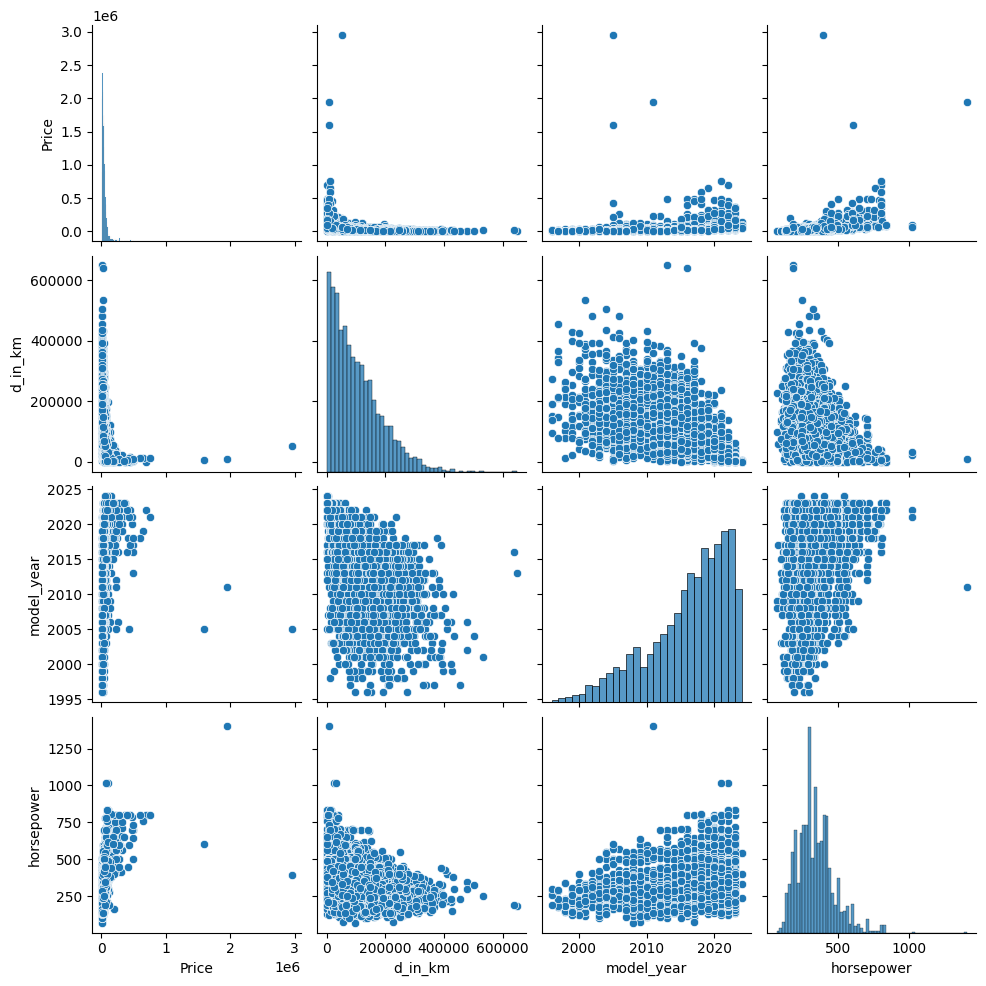

In [63]:
# Scatter plot for numerical features
import seaborn as sns
num_features = ["Price", "d_in_km", "model_year","horsepower"]
sns.pairplot(df[num_features], size = 2.5)
plt.show();


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3964 entries, 0 to 4008
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         3964 non-null   object 
 1   model         3964 non-null   object 
 2   model_year    3964 non-null   int64  
 3   fuel_type     3794 non-null   object 
 4   ext_col       3949 non-null   object 
 5   int_col       3835 non-null   object 
 6   accident      3964 non-null   object 
 7   clean_title   3964 non-null   object 
 8   horsepower    3767 non-null   float64
 9   Displacement  3771 non-null   float64
 10  Cylinders     3064 non-null   object 
 11  Gear          2536 non-null   float64
 12  Transmission  3529 non-null   object 
 13  d_in_km       3964 non-null   float64
 14  Price         3964 non-null   int32  
dtypes: float64(4), int32(1), int64(1), object(9)
memory usage: 480.0+ KB


Text(0, 0.5, 'Price')

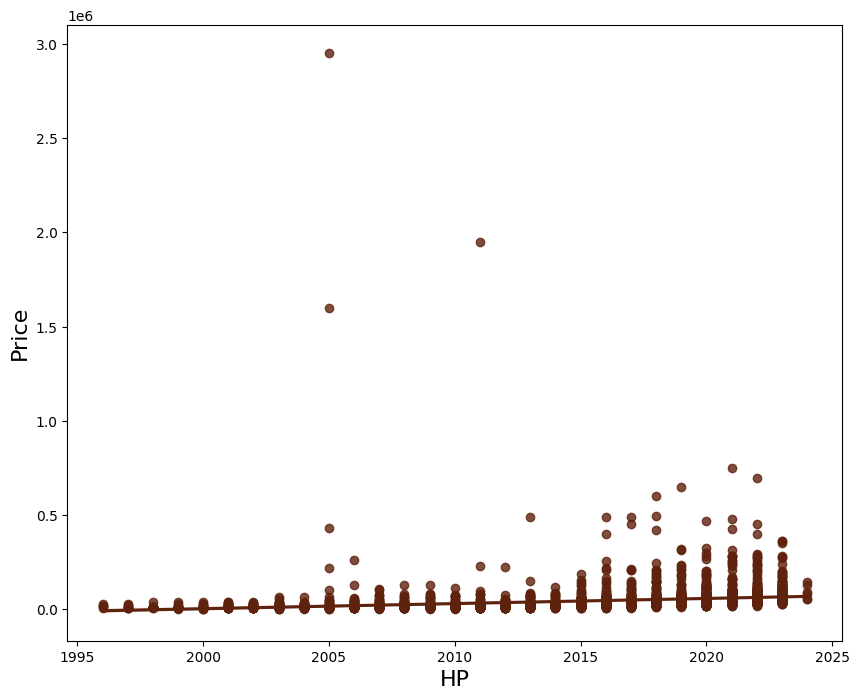

In [65]:

plt.figure(figsize=(10,8))
sns.regplot(x='model_year',y='Price',data=df,color='#5F220D')
plt.xlabel("HP",size=16)
plt.ylabel("Price",size=16)

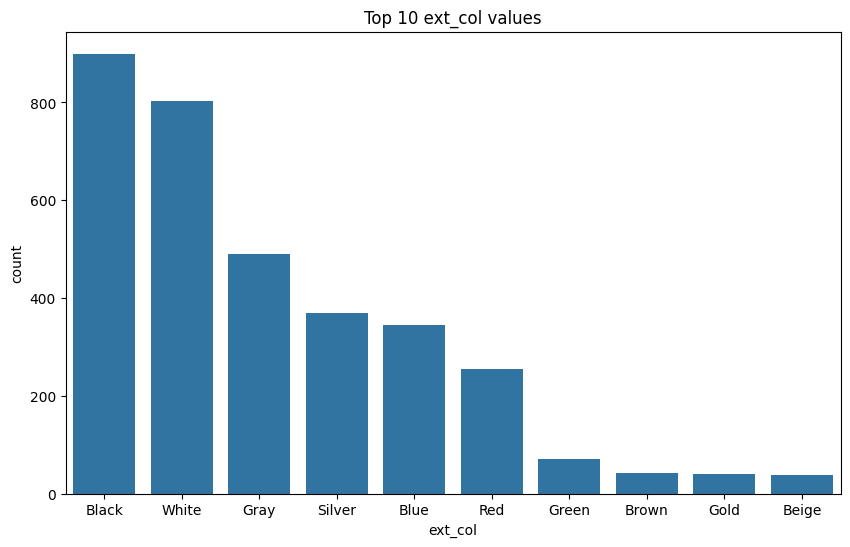

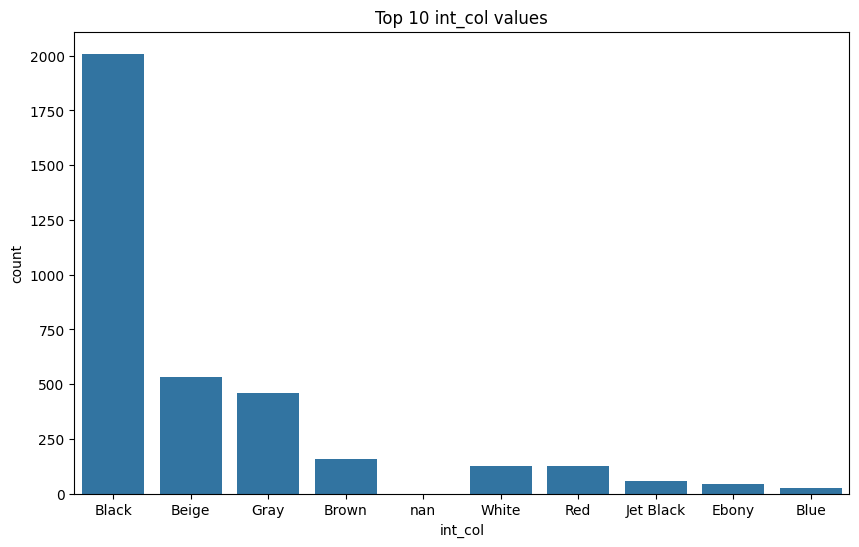

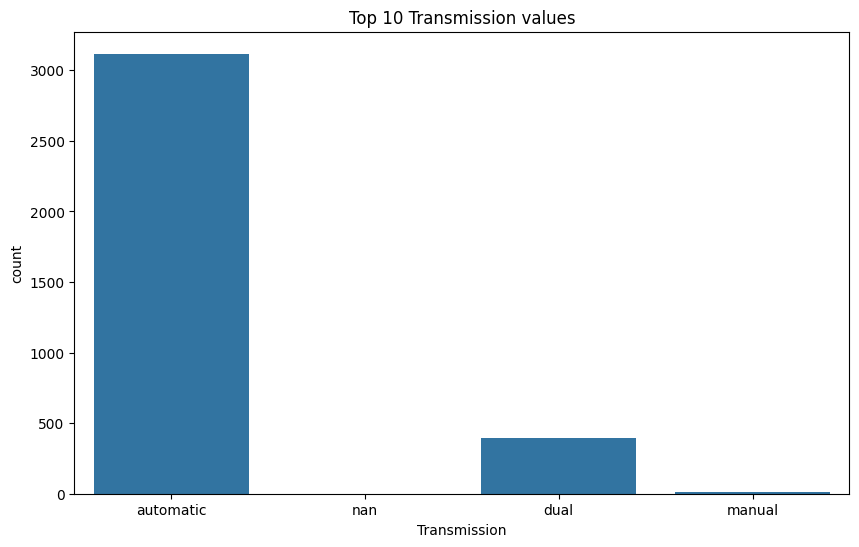

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train is your training dataset

graph = ["ext_col", "int_col", "Transmission"]

for col in graph:
    top_values = df[col].value_counts(dropna=False).head(10)

    # Create subplots for better visualization
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df, order=top_values.index)
    plt.title(f'Top 10 {col} values')
    plt.show()

In [67]:
# we are handiling null values of these 3 columns before spliting because of encoding part:

columns=['ext_col','int_col']
for col in columns:
  df[col].fillna("Black",inplace=True)

df['Transmission'].fillna("automatic",inplace=True)


In [68]:
df['Transmission'].value_counts(dropna=False)

Transmission
automatic    3553
dual          396
manual         15
Name: count, dtype: int64

In [69]:
df['ext_col'].value_counts(dropna=False)

ext_col
Black                       915
White                       804
Gray                        491
Silver                      370
Blue                        344
                           ... 
Sangria Red                   1
designo Diamond White         1
Anthracite Blue Metallic      1
Moonlight Cloud               1
C / C                         1
Name: count, Length: 316, dtype: int64

## Encoding 

In [70]:
from sklearn.preprocessing import OrdinalEncoder

# Define the categories for the OrdinalEncoder
categories = [1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
              2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
              2018, 2019, 2020, 2021, 2022, 2023, 2024]
transmission_categories = ['automatic', 'dual', 'manual']

brand_categories=['Acura', 'Alfa', 'Aston', 'Audi', 'BMW', 'Bentley', 'Bugatti',
       'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT',
       'Ferrari', 'Ford', 'GMC', 'Genesis', 'Honda', 'Hummer', 'Hyundai',
       'INFINITI', 'Jaguar', 'Jeep', 'Karma', 'Kia', 'Lamborghini',
       'Land', 'Lexus', 'Lincoln', 'Lotus', 'Lucid', 'MINI', 'Maserati',
       'Maybach', 'Mazda', 'McLaren', 'Mercedes Benz', 'Mercury',
       'Mitsubishi', 'Nissan', 'Plymouth', 'Polestar', 'Pontiac',
       'Porsche', 'RAM', 'Rivian', 'Rolls Royce', 'Saab', 'Saturn',
       'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen',
       'Volvo', 'smart']

oe = OrdinalEncoder(categories=[categories, transmission_categories, brand_categories], handle_unknown="use_encoded_value", unknown_value = -1)
oe_data = oe.fit_transform(df[["model_year",'Transmission','brand']])
df[["model_year",'Transmission','brand']] = oe_data


In [71]:
from sklearn.preprocessing import LabelEncoder

target_columns = ['clean_title', 'fuel_type', 'model','ext_col', 'int_col']

le = LabelEncoder()

# Apply label encoding
for col in target_columns:
    df[col] = le.fit_transform(df[col])

In [72]:
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(sparse_output = False, drop = "first")

# arr = ohe.fit_transform(df[['brand']])




In [73]:
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(sparse=False, drop="first")

# arr = ohe.fit_transform(df[['brand']])
# df_encoded = pd.DataFrame(arr, columns=ohe.get_feature_names_out(['brand']))

# # Concatenate the new one-hot encoded columns to the original DataFrame
# df = pd.concat([df, df_encoded], axis=1)

In [74]:
# one_hot_df=pd.DataFrame(data = arr, columns = ohe.get_feature_names_out(), index = df.index)
# df = pd.concat([df, one_hot_df], axis=1)
# df

In [75]:
df['accident'] = df['accident'].astype(int)

In [76]:
df.shape

(3964, 15)

In [77]:
df.isnull().sum()[df.isnull().sum()>0] 

horsepower       197
Displacement     193
Cylinders        900
Gear            1428
dtype: int64

In [78]:
df.isnull().sum()[df.isnull().sum()>0]


horsepower       197
Displacement     193
Cylinders        900
Gear            1428
dtype: int64

 ## Outlier Detector

In [79]:
# plt.boxplot(df['Price'], vert=False)
# plt.title("Detecting outliers using Boxplot")
# plt.xlabel('Sample')
# plt.show()

In [80]:
outliers = []
def detect_outliers_zscore(data):
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
sample_outliers = detect_outliers_zscore(np.log(df['Price']))
print("Outliers from Z-scores method: ", sample_outliers)
len(sample_outliers)

Outliers from Z-scores method:  [7.7406644019172415, 12.942039823273047, 12.971535836496138, 14.483850056813651, 13.099872339568797, 7.600902459542082, 13.016991750573663, 13.45166712454693, 14.898698839173656, 13.384726103409099, 13.102150465953114, 13.10011776845701, 13.527761816623505, 13.303016877097587, 13.060275185090907, 12.89896979483491, 13.0169828615465, 13.081530966163154, 14.284888991816091, 12.959844447906553, 7.7406644019172415, 13.105900606573208, 12.899094818276968]


23

In [81]:
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score = (i - mean) / std
        if np.abs(z_score) > thres:
            outliers.append(i)
    return outliers

sample_outliers = detect_outliers_zscore(np.log(df['Price']))
print("Outliers from Z-scores method: ", sample_outliers)

mean_price = np.mean(df['Price'])

# Replace outliers with the mean
for outlier in sample_outliers:
    df.loc[df['Price'] == outlier, 'Price'] = mean_price

Outliers from Z-scores method:  [7.7406644019172415, 12.942039823273047, 12.971535836496138, 14.483850056813651, 13.099872339568797, 7.600902459542082, 13.016991750573663, 13.45166712454693, 14.898698839173656, 13.384726103409099, 13.102150465953114, 13.10011776845701, 13.527761816623505, 13.303016877097587, 13.060275185090907, 12.89896979483491, 13.0169828615465, 13.081530966163154, 14.284888991816091, 12.959844447906553, 7.7406644019172415, 13.105900606573208, 12.899094818276968]


In [82]:
print((np.log(df['Price'])).mean())
(np.log(df['Price'])).std()

10.30931833841053


0.8451084936081167

<Axes: xlabel='d_in_km', ylabel='Density'>

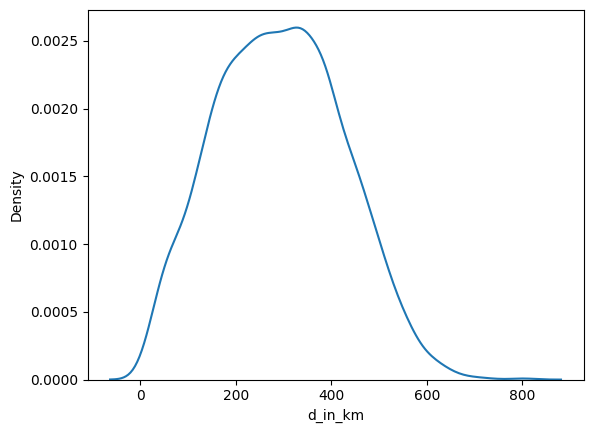

In [83]:
sns.kdeplot(np.sqrt(df['d_in_km']))

In [84]:
# outliers = []
# def detect_outliers_iqr(data):
#     data = sorted(data)
#     q1 = np.percentile(data, 25)
#     q3 = np.percentile(data, 75)
#     # print(q1, q3)
#     IQR = q3-q1
#     lwr_bound = q1-(1.5*IQR)
#     upr_bound = q3+(1.5*IQR)
#     # print(lwr_bound, upr_bound)
#     for i in data: 
#         if (i<lwr_bound or i>upr_bound):
#             outliers.append(i)
#     return outliers# Driver code
# sample_outliers = detect_outliers_iqr(df['Price'])
# print("Outliers from IQR method: ", sample_outliers)
# len(sample_outliers)

In [85]:
# sns.kdeplot(df['Price'])

In [86]:
# sns.kdeplot(np.sqrt(df["Price"]))

In [87]:
# df["Price_bin"] = pd.cut(df['Price'], bins=np.arange(1000, 3000000, 250))
# df['Price_bin'] = df['Price_bin'].astype(str).str.split(',').str[1].str.replace(']', '').astype(float)
# len(df['Price_bin'].value_counts())

In [88]:
# sns.boxplot(np.log(df["Price"]))

In [89]:
# sns.kdeplot(np.log(df["Price"]))

In [90]:
# outliers = []
# def detect_outliers_zscore(data):
#     thres = 3
#     mean = np.mean(data)
#     std = np.std(data)
#     # print(mean, std)
#     for i in data:
#         z_score = (i-mean)/std
#         if (np.abs(z_score) > thres):
#             outliers.append(i)
#     return outliers# Driver code
# sample_outliers = detect_outliers_zscore(np.log(df["Price"]))
# print("Outliers from Z-scores method: ", sample_outliers)
# len(sample_outliers)

In [91]:
# np.mean(df['Price'])

In [92]:
# np.log(df["Price"]).mean()

In [93]:
# median = np.median(np.log(df["Price"]))
# # Replace with median
# for i in sample_outliers:     
#     c = np.where(sample==i, 14, sample) 
#     print("Sample: ", np.log(df["Price"]))) 
#     print("New array: ",c) # print(x.dtype)

## LOG Transform 

In [103]:
df_nw = df.copy()
df_nw['Price'] = np.log(df["Price"])

df_nw['Price']
df_nw

,brand,model,model_year,fuel_type,ext_col,int_col,accident,clean_title,horsepower,Displacement,Cylinders,Gear,Transmission,d_in_km,Price
0,14.0,1722,17.0,1,29,14,1,1,300.0,3.7,6,6.0,0.0,81600.0,9.239899
1,19.0,1166,25.0,2,184,70,1,1,333.0,3.8,NaN,8.0,0.0,55587.2,10.545473
2,27.0,1307,26.0,2,38,14,0,0,NaN,3.5,NaN,NaN,0.0,35795.2,10.907753
3,20.0,1224,19.0,3,29,14,0,1,354.0,3.5,6,7.0,0.0,142240.0,9.648595
4,3.0,1207,25.0,2,119,14,0,0,416.0,2.0,NaN,8.0,0.0,15736.0,10.463075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,5.0,475,27.0,2,50,74,0,1,650.0,6.0,NaN,8.0,0.0,1142.4,12.765546
4005,3.0,1445,26.0,2,29,14,0,1,349.0,3.0,6,1.0,1.0,17440.0,10.894886
4006,43.0,1656,26.0,6,29,14,0,0,NaN,NaN,NaN,NaN,0.0,3385.6,11.418593
4007,14.0,654,24.0,2,38,14,0,1,450.0,3.5,6,NaN,0.0,52800.0,11.050874


## ** Splitting the data **

In [104]:
# df_nw=df.drop(columns=['price','milage','engine','transmission'])
df_nw

,brand,model,model_year,fuel_type,ext_col,int_col,accident,clean_title,horsepower,Displacement,Cylinders,Gear,Transmission,d_in_km,Price
0,14.0,1722,17.0,1,29,14,1,1,300.0,3.7,6,6.0,0.0,81600.0,9.239899
1,19.0,1166,25.0,2,184,70,1,1,333.0,3.8,NaN,8.0,0.0,55587.2,10.545473
2,27.0,1307,26.0,2,38,14,0,0,NaN,3.5,NaN,NaN,0.0,35795.2,10.907753
3,20.0,1224,19.0,3,29,14,0,1,354.0,3.5,6,7.0,0.0,142240.0,9.648595
4,3.0,1207,25.0,2,119,14,0,0,416.0,2.0,NaN,8.0,0.0,15736.0,10.463075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,5.0,475,27.0,2,50,74,0,1,650.0,6.0,NaN,8.0,0.0,1142.4,12.765546
4005,3.0,1445,26.0,2,29,14,0,1,349.0,3.0,6,1.0,1.0,17440.0,10.894886
4006,43.0,1656,26.0,6,29,14,0,0,NaN,NaN,NaN,NaN,0.0,3385.6,11.418593
4007,14.0,654,24.0,2,38,14,0,1,450.0,3.5,6,NaN,0.0,52800.0,11.050874


In [105]:
X = df_nw.drop(columns=["Price"])
y = df_nw["Price"]

In [106]:
# df[df["Price_bin"].isnull()>0]
# df['Price_bin'] = np.where(df['Price'] == 2000, 2000, np.where(df['Price'] == 2954083, 2954083, df['Price_bin']))

In [107]:
train, test, target, target_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [108]:
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=0)
print(f"shape of X: {X.shape}")
print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of X: (3964, 14)
shape of X_train: (2536, 14)
shape of X_test: (635, 14)
shape of y_train: (2536,)
shape of y_test: (635,)


In [110]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2536 entries, 1922 to 2732
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         2536 non-null   float64
 1   model         2536 non-null   float64
 2   model_year    2536 non-null   float64
 3   fuel_type     2536 non-null   float64
 4   ext_col       2536 non-null   float64
 5   int_col       2536 non-null   float64
 6   accident      2536 non-null   float64
 7   clean_title   2536 non-null   float64
 8   horsepower    2403 non-null   float64
 9   Displacement  2405 non-null   float64
 10  Cylinders     1930 non-null   float64
 11  Gear          1617 non-null   float64
 12  Transmission  2536 non-null   float64
 13  d_in_km       2536 non-null   float64
dtypes: float64(14)
memory usage: 297.2 KB


In [111]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 2536 entries, 1854 to 3245
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
2536 non-null   float64
dtypes: float64(1)
memory usage: 39.6 KB


In [112]:
# handling missing values
from sklearn.impute import SimpleImputer
missing_values=["horsepower","Displacement","Cylinders","Gear"]
si=SimpleImputer(strategy='median')
X_train[missing_values] = si.fit_transform(X_train[missing_values])
X_test[missing_values] = si.transform(X_test[missing_values])

In [113]:
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

In [114]:
X_train.isnull().sum()[X_train.isnull().sum()>0]

Series([], dtype: int64)

In [115]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [116]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(X_train)  
    ytest = model.predict(X_test)

    print('y_train= ', y_train[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(y_train, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(y_train, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(y_train, ytrain), 2)
    print('acc(rmse) for train =', acc_train_rmse_num)  
    print("--------------------------------------------")
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('y_test =', y_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(y_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(y_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(y_test, ytest), 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [117]:
# def important_features(model):
#     imp_df = pd.DataFrame({
#         "Varname": X_train.columns,
#         "Imp": model.feature_importances_
#     })
    
#     imp_df.sort_values(by = ["Imp"], ascending = False, inplace = True)
    
    
#     sns.barplot(data=imp_df.sort_values(by="Imp", ascending=False), x="Imp", y="Varname")

In [118]:
# model = LinearRegression(random_state=42)
# feature_selector = SelectFromModel(model)
# model.fit(X_train, y_train)

# important_features = X_train.columns[feature_selector.get_support()]
# print("Important Features:", important_features)

In [119]:
X_train

,brand,model,model_year,fuel_type,ext_col,int_col,accident,clean_title,horsepower,Displacement,Cylinders,Gear,Transmission,d_in_km
1922,-0.908030,1.414006,1.080050,-0.150143,0.272651,1.174088,-0.577472,0.421823,-1.122708,-1.684154,-0.155902,1.126658,-0.334196,-0.415032
491,-1.455553,1.287176,0.737378,-0.150143,1.323378,2.218372,-0.577472,0.421823,-1.075986,-0.909529,-1.342030,0.029720,-0.334196,-0.605908
1824,1.890422,1.627228,0.394705,2.921496,-1.128317,-0.539609,-0.577472,0.421823,0.434691,-1.191211,-1.342030,-1.798510,2.773532,-0.462450
1837,0.430360,-0.756813,-0.290639,-0.150143,1.323378,-0.539609,-0.577472,0.421823,-1.270661,-1.472893,-1.342030,0.029720,-0.334196,0.124773
1432,-1.212210,1.588628,-0.461975,-0.150143,1.323378,-0.539609,-0.577472,0.421823,0.434691,0.498880,1.030225,0.761012,-0.334196,-0.118150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-0.968866,-0.604249,0.737378,-0.150143,-1.128317,-0.539609,-0.577472,0.421823,0.590430,1.766448,1.030225,1.492304,-0.334196,1.067772
835,1.768750,0.026226,-3.203353,-0.150143,1.323378,-0.646715,-0.577472,0.421823,-1.029264,0.569300,-0.155902,-0.701572,-0.334196,2.846655
1653,1.221227,-1.679550,0.566041,-0.150143,-0.248222,0.959876,-0.577472,0.421823,0.395756,1.414345,1.030225,0.761012,-0.334196,-0.989114
2607,-0.603851,-0.481095,0.908714,-0.150143,-0.248222,-0.539609,-0.577472,0.421823,0.824040,-0.134904,-0.155902,1.492304,-0.334196,-0.742633


In [120]:
 linreg = LinearRegression()
linreg.fit(X_train, y_train)
acc_model(0,linreg,X_train,X_test)

y_train=  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
ytrain =  [10.2081664  10.21284066 10.55694758  9.67649436 10.42875876]
acc(r2_score) for train = 76.73
acc(relative error) for train = 2.91
acc(rmse) for train = 0.41
--------------------------------------------
y_test = [10.76848499 10.16585182 10.73639668 10.63344871 10.47728798]
ytest = [10.97749707 10.46883523 11.26562475 10.67947095 10.383984  ]
acc(r2_score) for test = 80.12
acc(relative error) for test = 2.86
acc(rmse) for test = 0.39


In [121]:
# Support Vector Machines
svr = SVR()
svr.fit(X_train,y_train )
acc_model(1,svr,X_train,X_test)

y_train=  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
ytrain =  [10.28183671 10.30720449 10.74564418  9.48471809 10.25564801]
acc(r2_score) for train = 88.15
acc(relative error) for train = 1.95
acc(rmse) for train = 0.29
--------------------------------------------
y_test = [10.76848499 10.16585182 10.73639668 10.63344871 10.47728798]
ytest = [10.94481909 10.11599012 11.11363151 10.59542468 10.35724959]
acc(r2_score) for test = 84.91
acc(relative error) for test = 2.44
acc(rmse) for test = 0.34


In [122]:
# Linear SVR

linear_svr = LinearSVR()
linear_svr.fit(X_train, y_train)
acc_model(2,linear_svr,X_train,X_test)

y_train=  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
ytrain =  [10.27089557 10.2921516  10.56624878  9.64062094 10.43690492]
acc(r2_score) for train = 76.05
acc(relative error) for train = 2.86
acc(rmse) for train = 0.41
--------------------------------------------
y_test = [10.76848499 10.16585182 10.73639668 10.63344871 10.47728798]
ytest = [10.98012427 10.36482607 11.25382635 10.60234735 10.41816721]
acc(r2_score) for test = 79.93
acc(relative error) for test = 2.79
acc(rmse) for test = 0.39


In [123]:
# Stochastic Gradient Descent

sgd = SGDRegressor(random_state=42)
sgd.fit(X_train, y_train)
acc_model(3,sgd,X_train,X_test)

y_train=  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
ytrain =  [10.23956773 10.24949622 10.55499118  9.68783458 10.42617935]
acc(r2_score) for train = 76.69
acc(relative error) for train = 2.91
acc(rmse) for train = 0.41
--------------------------------------------
y_test = [10.76848499 10.16585182 10.73639668 10.63344871 10.47728798]
ytest = [10.99115523 10.43352366 11.25298131 10.692635   10.36154931]
acc(r2_score) for test = 80.19
acc(relative error) for test = 2.85
acc(rmse) for test = 0.39


In [124]:
# Decision Tree Regression

decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)
acc_model(4,decision_tree,train,test)
# important_features(decision_tree)

y_train=  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
ytrain =  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
acc(r2_score) for train = 100.0
acc(relative error) for train = 0.0
acc(rmse) for train = 0.0
--------------------------------------------
y_test = [10.76848499 10.16585182 10.73639668 10.63344871 10.47728798]
ytest = [10.40423254 10.20359214 10.58405595 10.79957558 10.20173858]
acc(r2_score) for test = 76.69
acc(relative error) for test = 3.01
acc(rmse) for test = 0.42


In [125]:
# Random Forest

#random_forest = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': [100, 1000]}, cv=5)
random_forest = RandomForestRegressor(random_state=0)
random_forest.fit(X_train, y_train)
acc_model(5,random_forest,X_train,X_test)
# important_features(random_forest)

y_train=  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
ytrain =  [10.2644199  10.38819457 10.72982242  9.58658731  9.96780332]
acc(r2_score) for train = 97.89
acc(relative error) for train = 0.84
acc(rmse) for train = 0.12
--------------------------------------------
y_test = [10.76848499 10.16585182 10.73639668 10.63344871 10.47728798]
ytest = [10.88560916 10.1032368  10.86318864 10.67900412 10.31388244]
acc(r2_score) for test = 88.96
acc(relative error) for test = 2.03
acc(rmse) for test = 0.29


In [126]:
# y_pred = random_forest.predict(X_test)

In [127]:
# from sklearn.metrics import r2_score

# # Calculate R-squared
# r_squared = r2_score(y_test, y_pred)

# # Calculate Adjusted R-squared (assuming n_features is the number of features in your model)
# n_features = X.shape[1]  # Replace with the actual number of features
# adjusted_r2 = 1 - ((1 - r_squared) * (len(y_test) - 1) / (len(y_test) - n_features - 1))

# print(f"R-squared: {r_squared}")
# print(f"Adjusted R-squared: {adjusted_r2}")


In [128]:
# print('Training Score: ', random_forest.score(X_train, y_train))
# print('Testing Score: ', random_forest.score(X_test, y_test))
# print('RMSE: ', np.sqrt(mean_squared_error(y_test, random_forest.predict(X_test))))

In [129]:
# from sklearn.model_selection import RandomizedSearchCV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 140, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10, 20, 50]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4, 8, 16]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# print(random_grid)

In [130]:
# from sklearn.model_selection import RandomizedSearchCV
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor(random_state = 42)
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                               n_iter = 100, scoring='neg_mean_absolute_error', 
#                               cv = 3, verbose=2, random_state=42, n_jobs=-1,
#                               return_train_score=True)

# # Fit the random search model
# rf_random.fit(X_train, y_train);

In [131]:
# rf_random.best_params_

In [132]:
# random_forest = RandomForestRegressor(n_estimators = 800,
#  min_samples_split = 2,
#  min_samples_leaf = 1,
#  max_features = 'sqrt',
#  max_depth = 114,
#  bootstrap = False)
# random_forest.fit(X_train, y_train)
# acc_model(5,random_forest,X_train,X_test)
# important_features(random_forest)

In [133]:
# Random Forest

# #random_forest = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': [100, 1000]}, cv=5)
# random_forest = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=20,min_samples_leaf=1,
#                                        n_estimators=100, oob_score=True)
# random_forest.fit(X_train, y_train)
# acc_model(10,random_forest,X_train,X_test)
# important_features(random_forest)

In [134]:
 # AdaBoost Regression

Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(X_train, y_train)
acc_model(6,Ada_Boost,X_train,X_test)

y_train=  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
ytrain =  [10.23678049 10.35922921 10.65859945  9.67902614 10.44331033]
acc(r2_score) for train = 77.58
acc(relative error) for train = 3.07
acc(rmse) for train = 0.4
--------------------------------------------
y_test = [10.76848499 10.16585182 10.73639668 10.63344871 10.47728798]
ytest = [11.11580656 10.37766701 11.58437892 10.56606345 10.25907889]
acc(r2_score) for test = 79.33
acc(relative error) for test = 3.03
acc(rmse) for test = 0.4


In [135]:
# Extra Trees Regressor
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
acc_model(7,etr,X_train,X_test)

y_train=  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
ytrain =  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
acc(r2_score) for train = 100.0
acc(relative error) for train = 0.0
acc(rmse) for train = 0.0
--------------------------------------------
y_test = [10.76848499 10.16585182 10.73639668 10.63344871 10.47728798]
ytest = [10.91573593 10.16904065 10.95556432 10.59462995 10.26556288]
acc(r2_score) for test = 89.13
acc(relative error) for test = 2.05
acc(rmse) for test = 0.29


In [136]:
# Bagging Regressor

bagging = BaggingRegressor(random_state=0)
bagging.fit(X_train, y_train)
acc_model(8,bagging,X_train,X_test)

y_train=  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
ytrain =  [10.16869704 10.42118456 10.61470119  9.50086936  9.91203977]
acc(r2_score) for train = 96.86
acc(relative error) for train = 0.97
acc(rmse) for train = 0.15
--------------------------------------------
y_test = [10.76848499 10.16585182 10.73639668 10.63344871 10.47728798]
ytest = [10.81719813 10.0027276  10.70811782 10.70316534 10.31837579]
acc(r2_score) for test = 87.76
acc(relative error) for test = 2.14
acc(rmse) for test = 0.31


In [137]:
# Ridge Regressor

ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
acc_model(9,ridge,X_train,X_test)

y_train=  [10.25748391 10.37349118 10.6454249   9.66459564  9.79255599]
ytrain =  [10.21051631 10.21260376 10.55769297  9.67692466 10.42942497]
acc(r2_score) for train = 76.73
acc(relative error) for train = 2.91
acc(rmse) for train = 0.41
--------------------------------------------
y_test = [10.76848499 10.16585182 10.73639668 10.63344871 10.47728798]
ytest = [10.97789033 10.46960596 11.26289701 10.67670737 10.38593916]
acc(r2_score) for test = 80.12
acc(relative error) for test = 2.86
acc(rmse) for test = 0.39


In [138]:
# print('Training Score: ', random_forest.score(train, target))
# print('Testing Score: ', random_forest.score(test, target_test))
# print('RMSE: ', np.sqrt(mean_squared_error(target_test, random_forest.predict(test))))

In [139]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Machines', 'Linear SVR', 
               'Stochastic Gradient Decent', 'Decision Tree Regressor', 'Random Forest','AdaBoost Regression',
               'Extra Trees Regressor','Bagging Regressor',
             'Ridge Regressor'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [140]:
pd.options.display.float_format = '{:,.2f}'.format

In [141]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


,Model,r2_train,r2_test,rmse_train,rmse_test
7,Extra Trees Regressor,100.00,89.13,0.00,0.29
5,Random Forest,97.89,88.96,0.12,0.29
8,Bagging Regressor,96.86,87.76,0.15,0.31
1,Support Vector Machines,88.15,84.91,0.29,0.34
3,Stochastic Gradient Decent,76.69,80.19,0.41,0.39
0,Linear Regression,76.73,80.12,0.41,0.39
9,Ridge Regressor,76.73,80.12,0.41,0.39
2,Linear SVR,76.05,79.93,0.41,0.39
6,AdaBoost Regression,77.58,79.33,0.40,0.40
4,Decision Tree Regressor,100.00,76.69,0.00,0.42


## gridsearch_cv 

<!-- # # Assuming y_train is a continuous target variable for regression
# rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# params = {
#     'max_depth': [2, 3, 5, 10, 20, 25,30],
#     'min_samples_leaf': [5, 10, 20, 50, 100],
#     'n_estimators': [10, 25, 30, 50, 100, 200]
# }

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=rf,
#                            param_grid=params,
#                            cv=4,
#                            n_jobs=-1, verbose=1, scoring="r2")
# # Use "neg_mean_squared_error" for regression problems
# # If you're interested in another metric, replace it accordingly

# grid_search.fit(train,target) -->

In [ ]:
# grid_search.best_score_

In [ ]:
# rf_best = grid_search.best_estimator_
# rf_best

In [ ]:
# rf_best.fit(train,target)

In [ ]:
# # Random Forest Regressor

# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=20,min_samples_leaf=5,
#                                        n_estimators=50, oob_score=True)

# rf.fit(train, target)

# print('Training Score: ', rf.score(train, target))
# print('Testing Score: ', rf.score(test, target_test))
# print('RMSE: ', np.sqrt(mean_squared_error(target_test, rf.predict(test))))

## **Splitting the data 2.0**

In [ ]:
# X=df.drop(columns=['price','milage','engine','transmission','Price','brand'])
# y=df['Price']


In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size = 0.20,
#                                                    random_state = 42)
# print(f"shape of X: {X.shape}")
# print(f"shape of X_train: {X_train.shape}")
# print(f"shape of X_test: {X_test.shape}")
# print(f"shape of y_train: {y_train.shape}")
# print(f"shape of y_test: {y_test.shape}")

In [ ]:
# X_train.isnull().sum()[X_train.isnull().sum()>0]

In [ ]:
train.info()

In [ ]:
# # handling missing values
# from sklearn.impute import SimpleImputer
# missing_values=["horsepower","Displacement","Cylinders","Gear"]
# si=SimpleImputer(strategy='median')
# X_train[missing_values] = si.fit_transform(X_train[missing_values])
# X_test[missing_values] = si.transform(X_test[missing_values])

In [ ]:
train.isnull().sum()[train.isnull().sum()>0]
# with this null values are handelled:

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# mms = MinMaxScaler()
# X_train_scaled = pd.DataFrame(mms.fit_transform(X_train), index = X_train.index, columns = X_train.columns)
# X_test_scaled = pd.DataFrame(mms.transform(X_test), index = X_test.index, columns = X_test.columns)

In [ ]:
train

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(train, target)
acc_model(0,linreg,train,test)

In [ ]:
# Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)

print('Training Score: ', lr.score(X_train, y_train))
print('Testing Score: ', lr.score(X_test, y_test))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, lr.predict(X_test))))

In [ ]:
X_train

In [ ]:
numerical_cols=['model_year','horsepower','Displacement','Cylinders','Gear','Transmission','d_in_km']

In [ ]:
# Standardize numerical columns

scaler = MinMaxScaler()
#scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

dt = DecisionTreeRegressor(random_state=42)

dt.fit(X_train, y_train)

print('Training Score: ', dt.score(X_train, y_train))
print('Testing Score: ', dt.score(X_test, y_test))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, dt.predict(X_test))))


In [ ]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=10,n_estimators=10000, oob_score=True)

rf.fit(X_train, y_train)

print('Training Score: ', rf.score(X_train,y_train))
print('Testing Score: ', rf.score(X_test, y_test))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, rf.predict(X_test))))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Assuming y_train is a continuous target variable for regression
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

params = {
    'max_depth': [2, 3, 5, 10, 20, 25,30],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'n_estimators': [10, 25, 30, 50, 100, 200]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="r2")
# Use "neg_mean_squared_error" for regression problems
# If you're interested in another metric, replace it accordingly

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_score_

In [ ]:
rf_best = grid_search.best_estimator_
rf_best

In [ ]:
rf_best.fit(X_train,y_train)

In [ ]:
rf_best.score(X_train,y_train)

In [ ]:
print(rf_best.score(X_test,y_test))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, rf_best.predict(X_test))))

In [ ]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=20,min_samples_leaf=5,
                                       n_estimators=10, oob_score=True)

rf.fit(X_train, y_train)

print('Training Score: ', rf.score(X_train, y_train))
print('Testing Score: ', rf.score(X_test, y_test))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, rf.predict(X_test))))

In [ ]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf.feature_importances_
})

imp_df.sort_values(by = ["Imp"], ascending = False, inplace = True)


sns.barplot(data=imp_df.sort_values(by="Imp", ascending=False), x="Imp", y="Varname")

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors= 10, weights= 'distance')
knn.fit(X_train,y_train)

In [ ]:
knn.score(X_train, y_train)
knn.score(X_test, y_test)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

ada=AdaBoostRegressor()
ada.fit(X_train, y_train)

In [ ]:
ada.score(X_train,y_train)

In [ ]:
ada.score(X_test,y_test)

In [ ]:
print('RMSE: ', np.sqrt(mean_squared_error(y_test, ada.predict(X_test))))

In [ ]:
from sklearn.ensemble import BaggingRegressor
#Bagging Models
knn_bag = BaggingRegressor(base_estimator = knn,n_estimators = 3,random_state = 0)

In [ ]:
knn_bag.fit(X_train, y_train)

In [ ]:
knn_bag.score(X_train,y_train)

In [ ]:
knn_bag.score(X_test,y_test)

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True,ax=ax,annot=True)

##  after getting accuraccy 

In [ ]:
'''important columns for input:
1.horsepower
2. d_in_km
3. model_year
4. displacement
5. model
6.brand,
7.ext_col
8.cylinders
9. int_col
10. fuel_type
11. gear'''


In [ ]:
df['model'].value_counts()

In [ ]:
df['model_year'].unique()

In [ ]:
df[df['model_year']== 2024]

In [75]:
df['fuel_type'].unique()

array(['E85 Flex Fuel', 'Gasoline', 'Hybrid', nan, 'Diesel',
       'Plug In Hybrid', 'Hydrogen Fuel'], dtype=object)